発見CSVファイル数: 16

📂 20251003142418-TorIP_geocoded
  総点数: 1135 / 正常: 1102 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-375374313.6782 / 異常=-38474795669.4799
  スコア範囲: min=-79680276839.7641 max=-0.9574


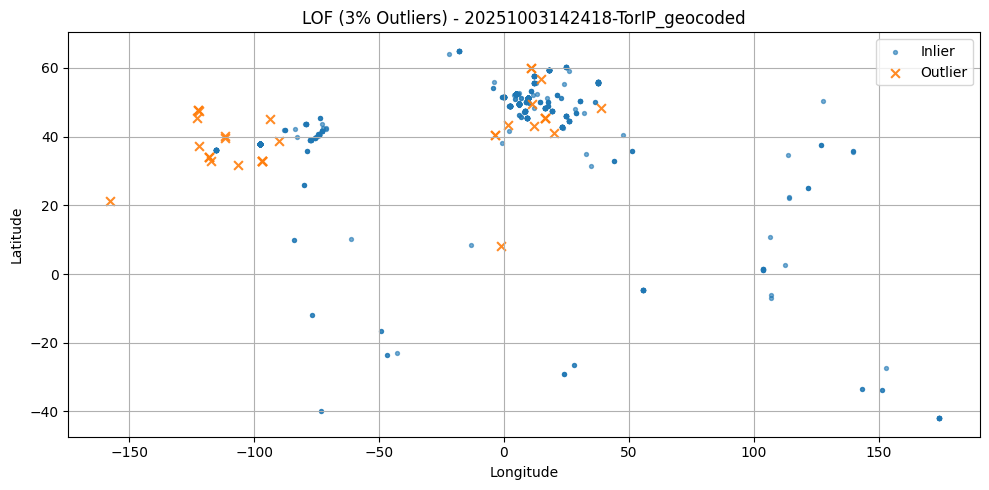


📂 20251003143810-TorIP_geocoded
  総点数: 1134 / 正常: 1101 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-375715253.1085 / 異常=-38474795669.4799
  スコア範囲: min=-79680276839.7641 max=-0.9574


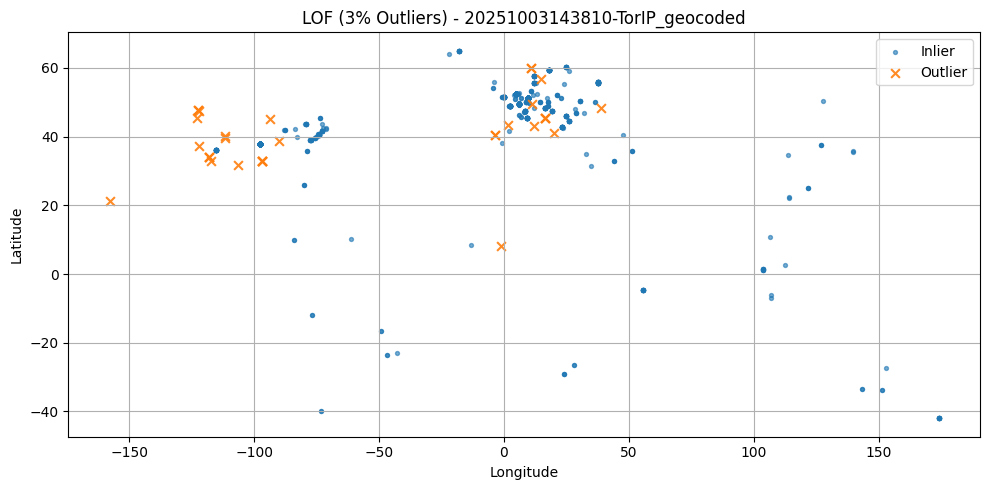


📂 20251003164852-TorIP_geocoded
  総点数: 1132 / 正常: 1099 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-376398993.3326 / 異常=-38474795669.4799
  スコア範囲: min=-79680276839.7641 max=-0.9574


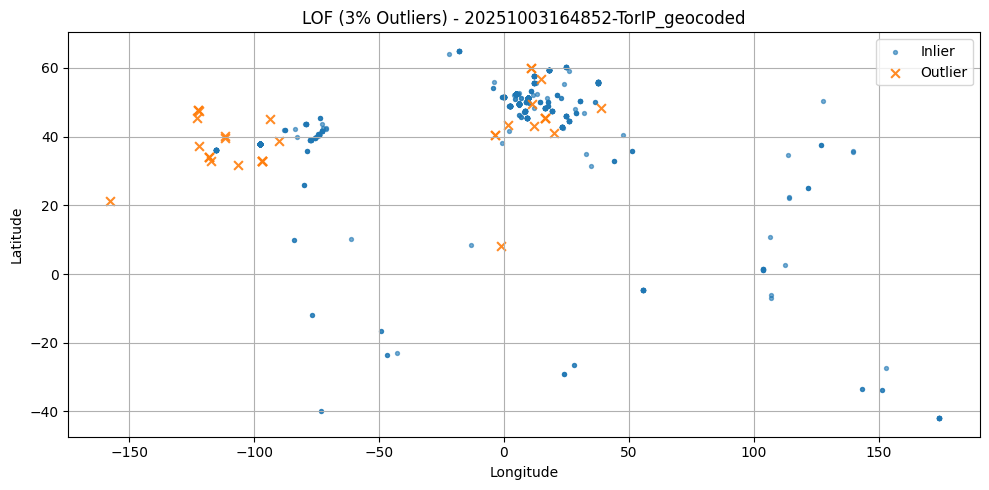


📂 20251003172946-TorIP_geocoded
  総点数: 1132 / 正常: 1099 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-376398993.3326 / 異常=-38474795669.4799
  スコア範囲: min=-79680276839.7641 max=-0.9574


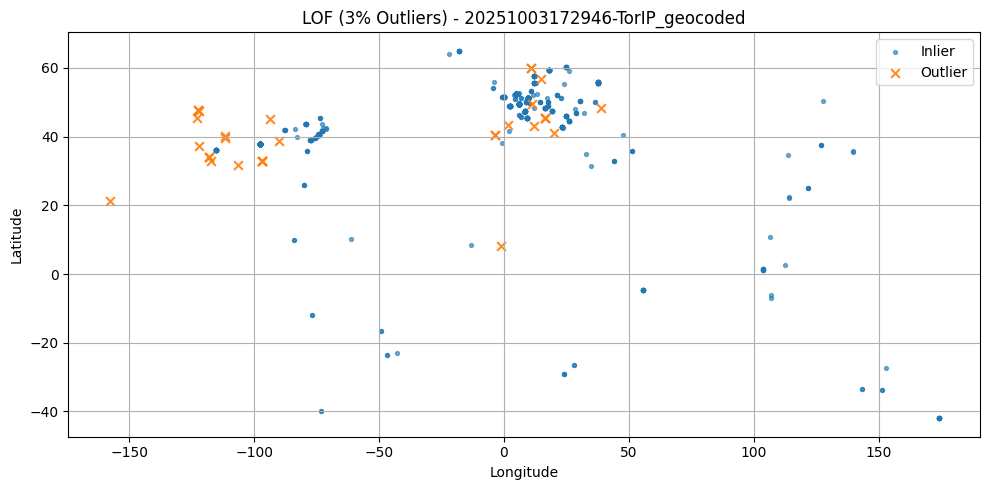


📂 20251003173524-TorIP_geocoded
  総点数: 1132 / 正常: 1099 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-376398993.3326 / 異常=-38474795669.4799
  スコア範囲: min=-79680276839.7641 max=-0.9574


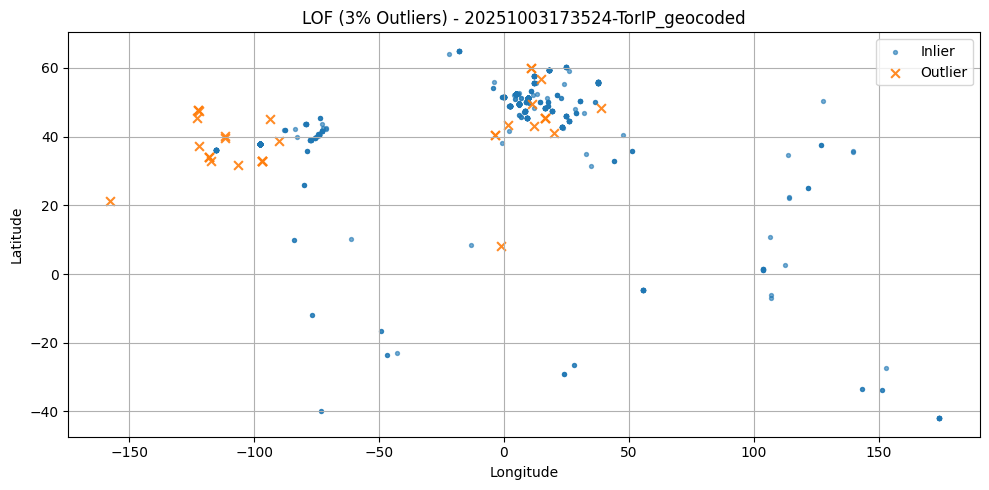


📂 20251004173514-TorIP_geocoded
  総点数: 1138 / 正常: 1106 / 異常: 32 (約 2.8% )
  スコア平均: 正常=-378921891.0924 / 異常=-37574919776.3680
  スコア範囲: min=-79680276839.7641 max=-0.9574


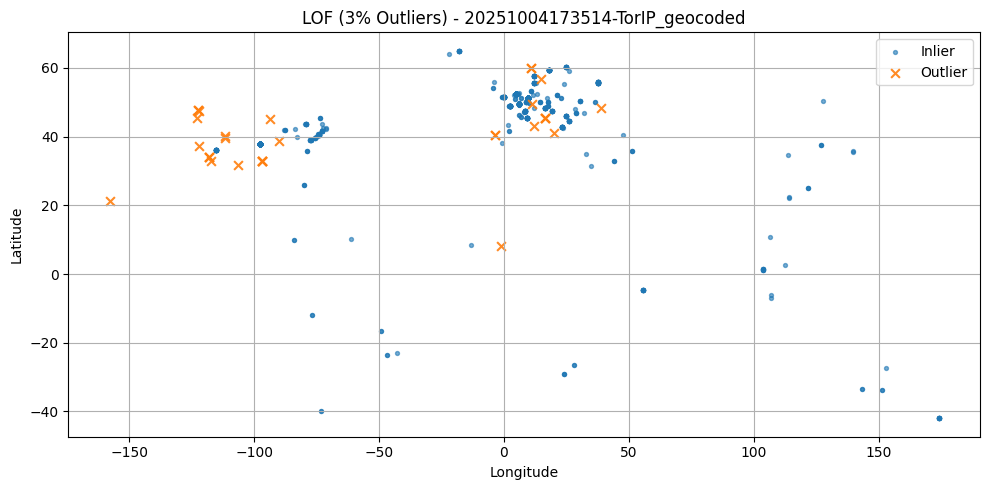


📂 20251005173523-TorIP_geocoded
  総点数: 1128 / 正常: 1095 / 異常: 33 (約 2.9% )
  スコア平均: 正常=-354885853.2474 / 異常=-37253727242.3868
  スコア範囲: min=-79680276839.7641 max=-0.9653


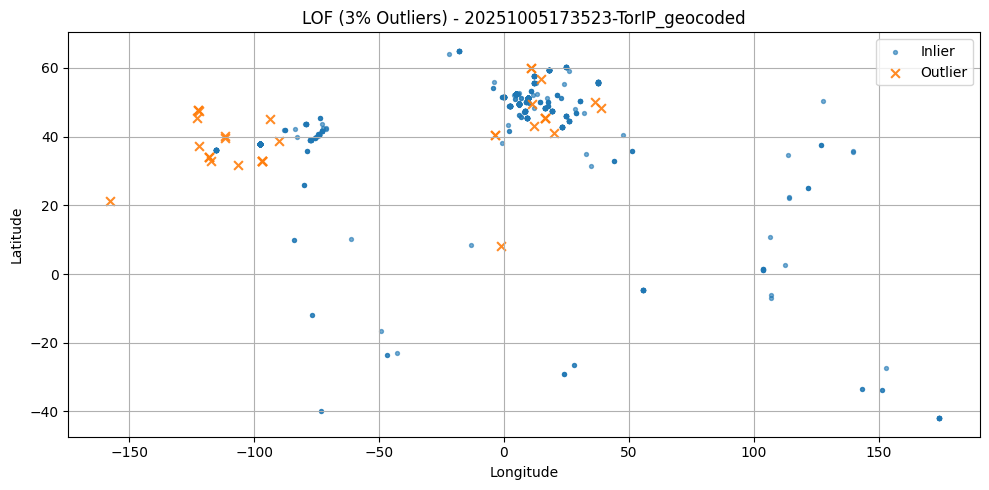


📂 20251006173520-TorIP_geocoded
  総点数: 1129 / 正常: 1097 / 異常: 32 (約 2.8% )
  スコア平均: 正常=-354244690.3735 / 異常=-38631721768.3215
  スコア範囲: min=-79680276839.7641 max=-0.9653


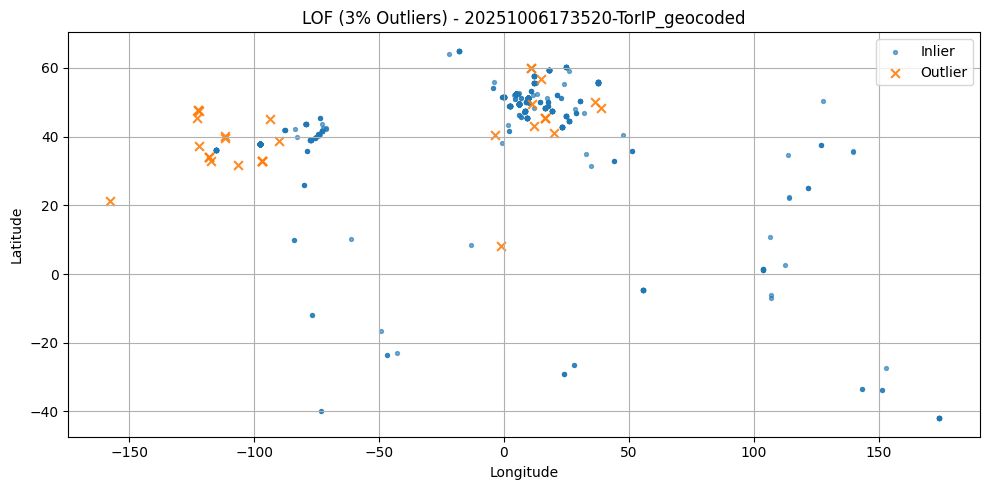


📂 20251007173522-TorIP_geocoded
  総点数: 1135 / 正常: 1101 / 異常: 34 (約 3.0% )
  スコア平均: 正常=-352957697.8459 / 異常=-34563880037.9003
  スコア範囲: min=-79680276839.7641 max=-0.9653


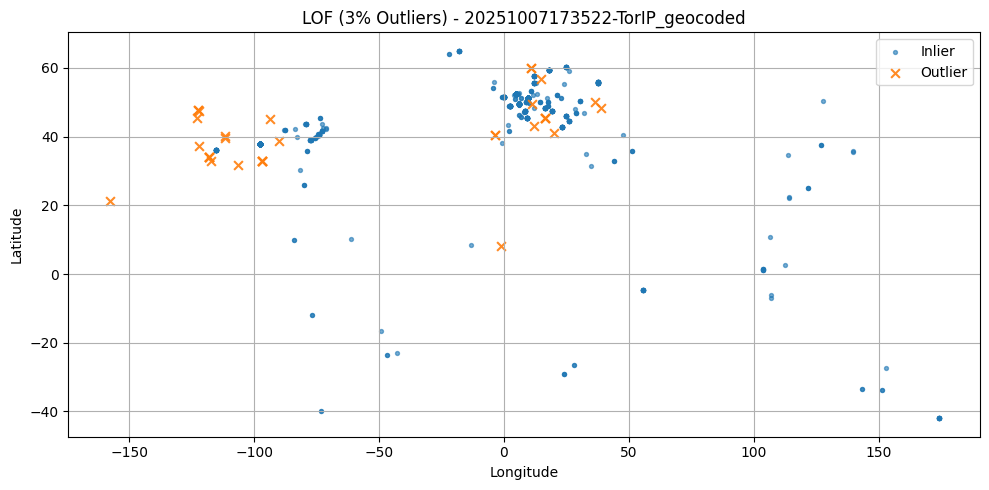


📂 20251008173518-TorIP_geocoded
  総点数: 1134 / 正常: 1100 / 異常: 34 (約 3.0% )
  スコア平均: 正常=-405160286.8762 / 異常=-34688395759.0487
  スコア範囲: min=-79680276839.7641 max=-0.9594


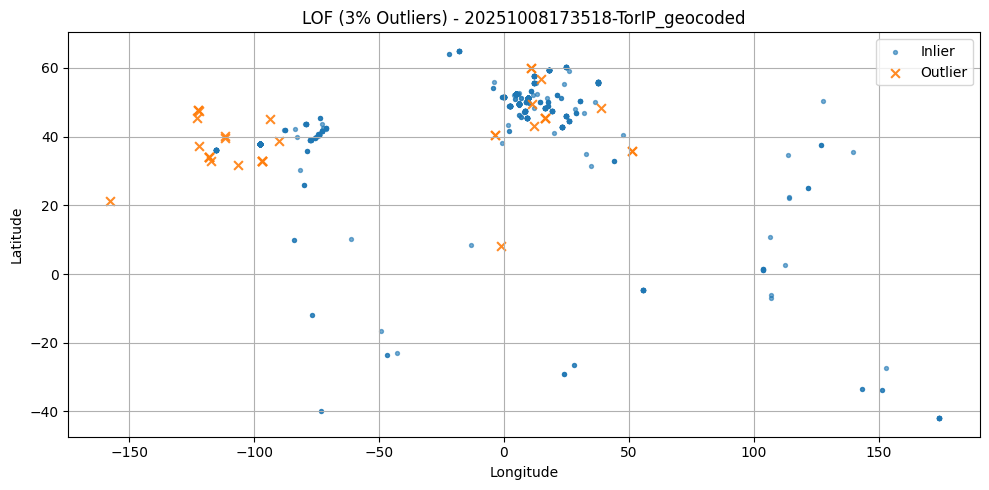


📂 20251009173527-TorIP_geocoded
  総点数: 1135 / 正常: 1101 / 異常: 34 (約 3.0% )
  スコア平均: 正常=-463143699.0660 / 異常=-68350961974.9719
  スコア範囲: min=-249096954206.6858 max=-0.9594


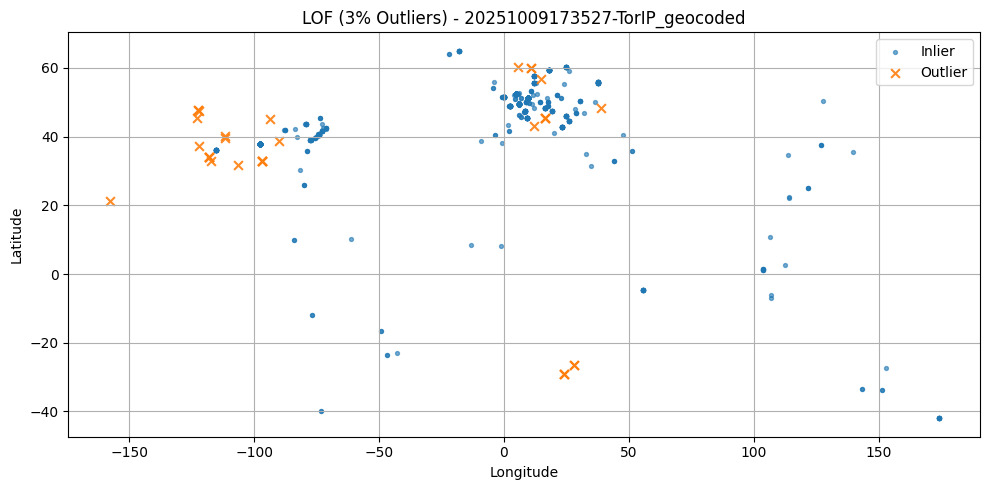


📂 20251010173526-TorIP_geocoded
  総点数: 1147 / 正常: 1112 / 異常: 35 (約 3.1% )
  スコア平均: 正常=-427548040.3422 / 異常=-68704527615.9276
  スコア範囲: min=-249096954206.6858 max=-0.9840


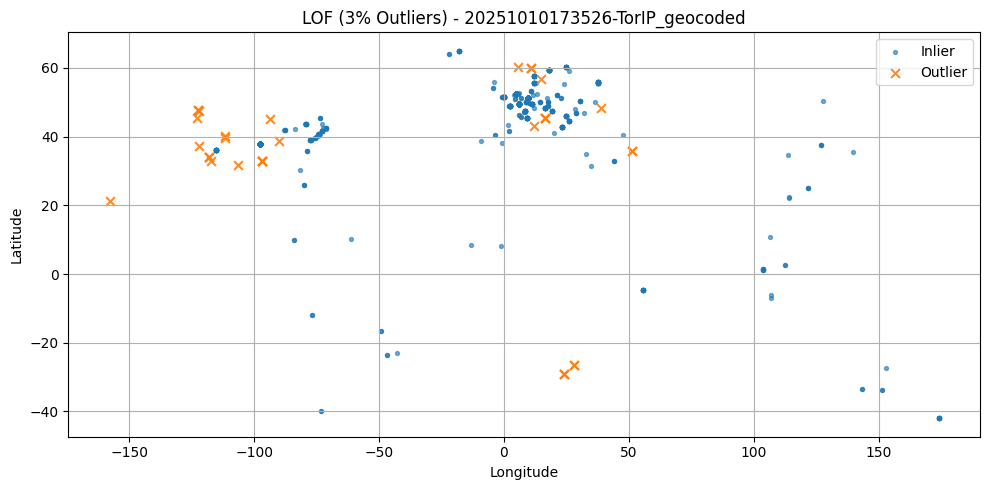


📂 20251011173523-TorIP_geocoded
  総点数: 1146 / 正常: 1111 / 異常: 35 (約 3.1% )
  スコア平均: 正常=-403883251.8285 / 異常=-67673616879.3989
  スコア範囲: min=-249096954206.6858 max=-0.9840


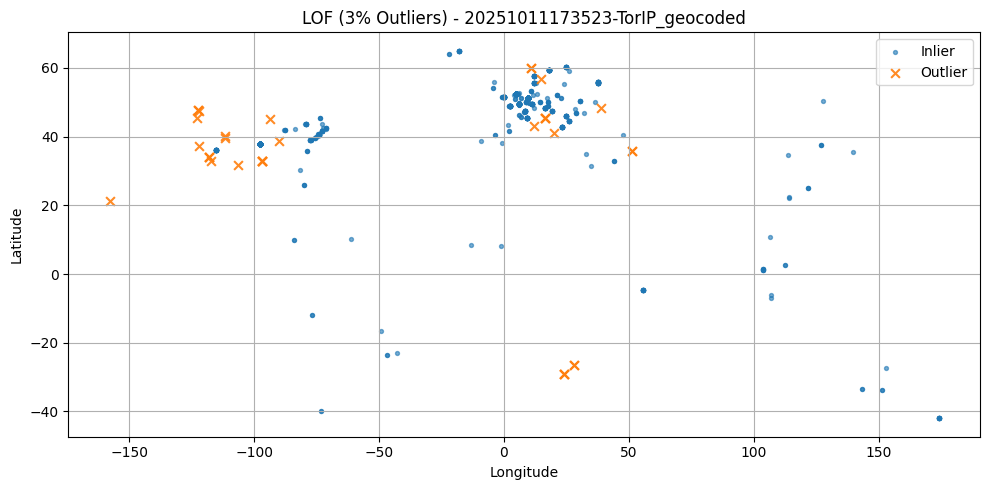


📂 20251012173526-TorIP_geocoded
  総点数: 1149 / 正常: 1117 / 異常: 32 (約 2.8% )
  スコア平均: 正常=-376868404.9833 / 異常=-37129295158.3739
  スコア範囲: min=-79680276839.7641 max=-0.9840


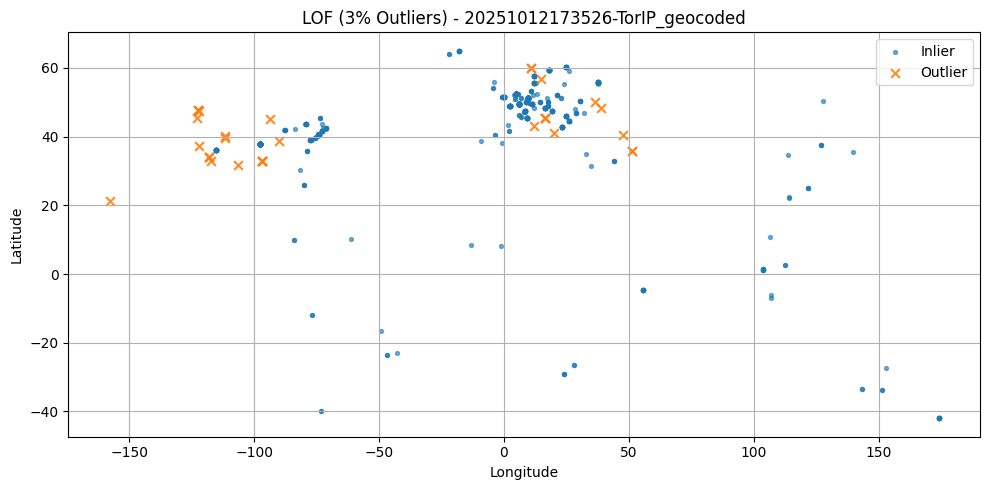


📂 20251013173525-TorIP_geocoded
  総点数: 1151 / 正常: 1119 / 異常: 32 (約 2.8% )
  スコア平均: 正常=-383621037.6791 / 異常=-37129295158.3739
  スコア範囲: min=-79680276839.7641 max=-0.9840


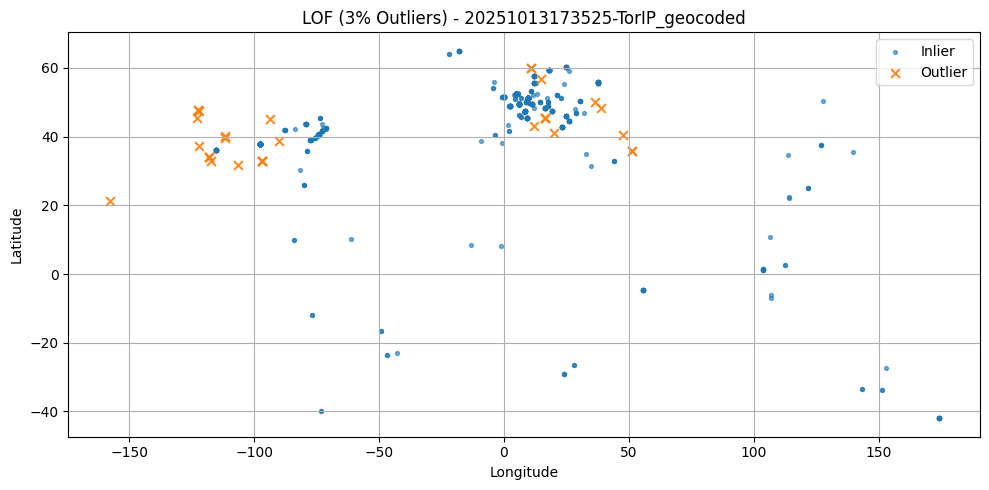


📂 20251014173524-TorIP_geocoded
  総点数: 1149 / 正常: 1117 / 異常: 32 (約 2.8% )
  スコア平均: 正常=-388283853.7988 / 異常=-40975445815.6844
  スコア範囲: min=-79680276839.7641 max=-0.9840


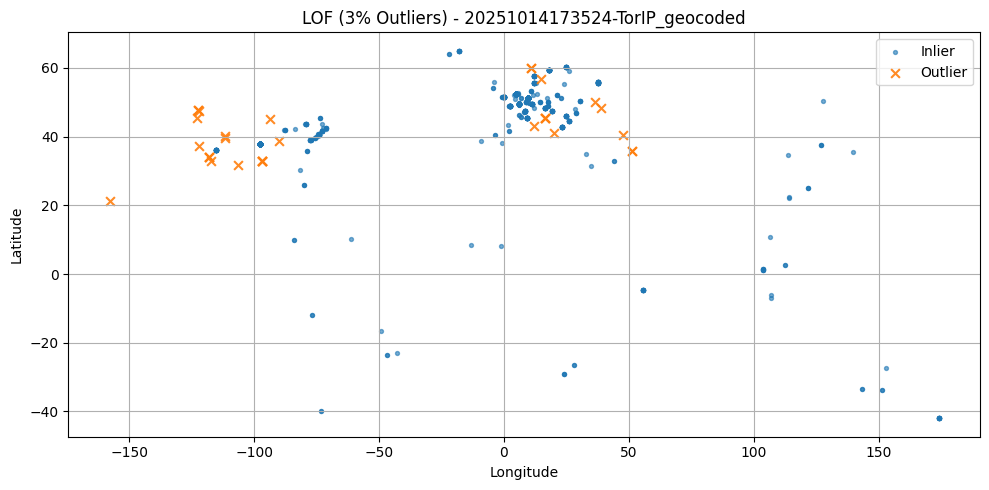

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# ===== 設定 =====
ZIP_PATH = "./isolation_forest.zip"
EXTRACT_DIR = "./isolation_forest_all"

# ===== ZIP展開 =====
os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

# ===== CSV一覧 =====
csv_files = []
for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, f))
csv_files.sort()
print(f"発見CSVファイル数: {len(csv_files)}")

# ===== 緯度経度検出関数 =====
def detect_lat_lon_columns(columns):
    lat = next((c for c in columns if "lat" in c.lower()), None)
    lon = next((c for c in columns if ("lon" in c.lower()) or ("lng" in c.lower()) or ("longi" in c.lower())), None)
    return lat, lon

# ===== 各ファイルを処理 =====
for path in csv_files:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[SKIP] 読み込み失敗 {path}: {e}")
        continue

    lat_col, lon_col = detect_lat_lon_columns(df.columns)
    if not lat_col or not lon_col:
        print(f"[SKIP] {os.path.basename(path)}: 緯度経度列が見つかりません")
        continue

    # ===== 前処理 =====
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df = df.dropna(subset=[lat_col, lon_col])
    df = df[(df[lat_col].between(-90, 90)) & (df[lon_col].between(-180, 180))]
    if len(df) < 5:
        continue

    X = df[[lon_col, lat_col]].to_numpy()
    n = len(X)

    # ===== LOF（外れ値3％） =====
    n_neighbors = max(10, min(35, int(n * 0.01)))
    if n_neighbors >= n:
        n_neighbors = max(5, n - 1)

    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.03)
    y_pred = lof.fit_predict(X)
    scores = lof.negative_outlier_factor_

    is_out = (y_pred == -1)
    inliers = ~is_out

    # ===== 結果出力 =====
    fname = os.path.basename(path).replace(".csv", "")
    print(f"\n📂 {fname}")
    print(f"  総点数: {n} / 正常: {inliers.sum()} / 異常: {is_out.sum()} (約 {is_out.sum()/n*100:.1f}% )")
    print(f"  スコア平均: 正常={scores[inliers].mean():.4f} / 異常={scores[is_out].mean():.4f}")
    print(f"  スコア範囲: min={scores.min():.4f} max={scores.max():.4f}")

    # ===== プロット =====
    plt.figure(figsize=(10, 5))
    plt.scatter(X[inliers, 0], X[inliers, 1], s=8, alpha=0.6, label="Inlier")
    plt.scatter(X[is_out, 0], X[is_out, 1], s=40, alpha=0.9, marker="x", label="Outlier")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"LOF (3% Outliers) - {fname}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
